In [2]:
# Add ldcpy root to system path
import sys

sys.path.insert(0, '../../../')

# Import ldcpy package
# Autoreloads package everytime the package is called, so changes to code will be reflected in the notebook if the above sys.path.insert(...) line is uncommented.
%load_ext autoreload
%autoreload 2
import ldcpy

# display the plots in this notebook
%matplotlib inline

In [12]:
pop_sst = ldcpy.open_datasets(
    ["SST"],
    ['../../../data/pop/pop.SST.100days.nc', '../../../data/pop/zfp1e-2.pop.SST.100days.nc'],
    ['orig', 'zfp'],
)
pop_sst

dataset size in GB 0.10



<xarray.Dataset>
Dimensions:     (collection: 2, nlat: 384, nlon: 320, time: 100)
Coordinates:
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time        (time) object 1920-01-03 00:00:00 ... 1920-04-12 00:00:00
  * collection  (collection) <U4 'orig' 'zfp'
Dimensions without coordinates: nlat, nlon
Data variables:
    SST         (collection, time, nlat, nlon) float32 dask.array<chunksize=(1, 100, 384, 320), meta=np.ndarray>
Attributes:
    title:         b.e11.B20TRC5CNBDRD.f09_g16.030
    history:       Fri Oct 30 11:42:30 2020: ncks -d time,0,99,1 b.e11.B20TRC...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2014-02-15 at 18:40:51.7
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  25
    tavg_sum:      86400.0
    NCO:           netCDF Operators version 4.7.9 (Homepage = http://nco.sf.n...

/Users/abaker/anaconda3/envs/ldcpy_dev/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


KeyError: 'lon'

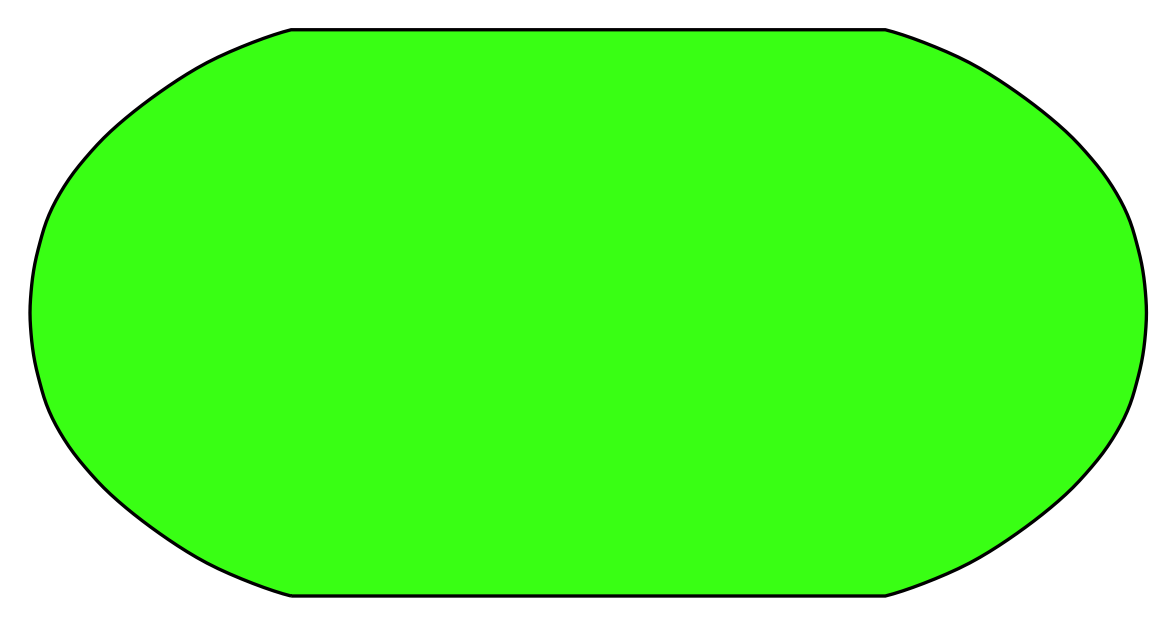

In [11]:
ldcpy.plot(pop_sst, "SST", sets=["orig"], calc="mean", plot_type="spatial")

In [10]:
ldcpy.compare_stats(pop_sst.isel(time=0), 'SST', 'orig', 'zfp', include_ssim_metric=False)

 
mean orig                          : 16.593
mean zfp                           : 16.594
mean diff                          : -0.00022196
 
variance orig                      : 117.39
variance zfp                       : 117.39
 
standard deviation orig            : 10.835
standard deviation zfp             : 10.835
 
max value orig                     : 30.528
max value zfp                      : 30.528
min value orig                     : -2.1639
min value zfp                      : -2.1641
 
max abs diff                       : 0.0045254
min abs diff                       : 0
mean abs diff                      : 0.0010493
mean squared diff                  : 4.9265e-08
root mean squared diff             : 0.0013037
normalized root mean squared diff  : 3.9878e-05
normalized max pointwise error     : 0.00013843
pearson correlation coefficient    : 1
ks p-value                         : 0.00013815
spatial relative error(% > 0.0001) : 16.759
max spatial relative error         : 1.7397
